In [ ]:
!pip install -q kaggle imbalanced-learn xgboost optuna matplotlib scikit-plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [ ]:
from google.colab import files
uploaded = files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
for fn in uploaded:
    !mkdir -p /root/.kaggle
    !cp {fn} /root/.kaggle/
    !chmod 600 /root/.kaggle/{fn}

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.27GB/s]


In [ ]:
df = pd.read_csv('/content/creditcard.csv')
print('Rows, Columns:', df.shape)
df.head()

Rows, Columns: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df['Class'].value_counts())
print('Fraction of fraud:', df['Class'].mean())
print(df.describe())

Class
0    284315
1       492
Name: count, dtype: int64
Fraction of fraud: 0.001727485630620034
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.48

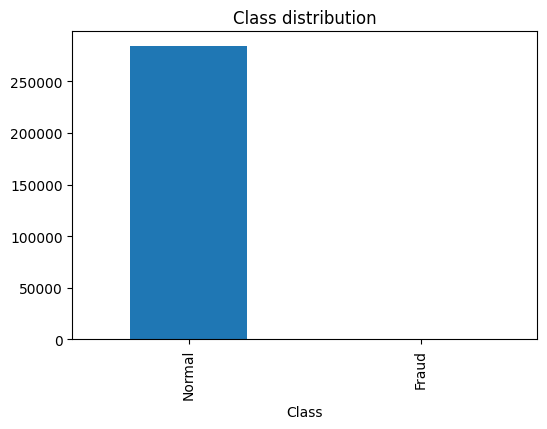

In [ ]:
plt.figure(figsize=(6,4))
ax = df['Class'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Normal','Fraud'])
plt.title('Class distribution')
plt.show()

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']
X['Amount_scaled'] = StandardScaler().fit_transform(X[['Amount']])
X = X.drop(['Amount'], axis=1)
X['Time_scaled'] = StandardScaler().fit_transform(X[['Time']])
X = X.drop(['Time'], axis=1)

In [ ]:
print(X.shape, y.shape)

(284807, 30) (284807,)


In [ ]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (227845, 30) Test size: (56962, 30)


In [ ]:
baseline_pipe = Pipeline([
('scaler', StandardScaler()),
('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
])
baseline_pipe.fit(X_train, y_train)


y_pred = baseline_pipe.predict(X_test)
y_proba = baseline_pipe.predict_proba(X_test)[:,1]
print('Baseline Logistic Regression')
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

Baseline Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC: 0.9720834996210077


In [ ]:
smote = SMOTE(random_state=RANDOM_SEED)
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_SEED)
pipe_rf = ImbPipeline([('scaler', StandardScaler()), ('smote', smote), ('rf', rf)])


pipe_rf.fit(X_train, y_train)


y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]
print('Random Forest + SMOTE')
print(classification_report(y_test, y_pred_rf))
print('ROC AUC:', roc_auc_score(y_test, y_proba_rf))

Random Forest + SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.81      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9714376693980913


In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
pipe_xgb = ImbPipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=RANDOM_SEED)), ('xgb', xgb_clf)])
pipe_xgb.fit(X_train, y_train)


y_pred_xgb = pipe_xgb.predict(X_test)
y_proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]
print('XGBoost + SMOTE')
print(classification_report(y_test, y_pred_xgb))
print('ROC AUC:', roc_auc_score(y_test, y_proba_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:14:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost + SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9799832109264639


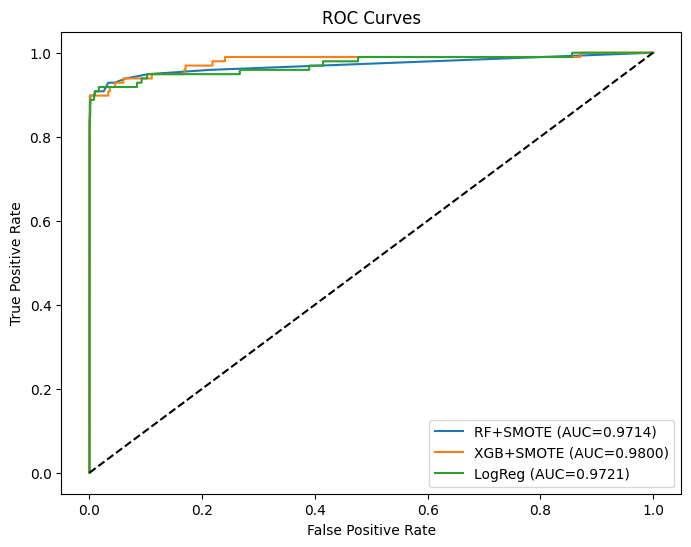

In [ ]:
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label=f'RF+SMOTE (AUC={roc_auc_score(y_test, y_proba_rf):.4f})')


fpr_x, tpr_x, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_x, tpr_x, label=f'XGB+SMOTE (AUC={roc_auc_score(y_test, y_proba_xgb):.4f})')


fpr_b, tpr_b, _ = roc_curve(y_test, y_proba)
plt.plot(fpr_b, tpr_b, label=f'LogReg (AUC={roc_auc_score(y_test, y_proba):.4f})')


plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

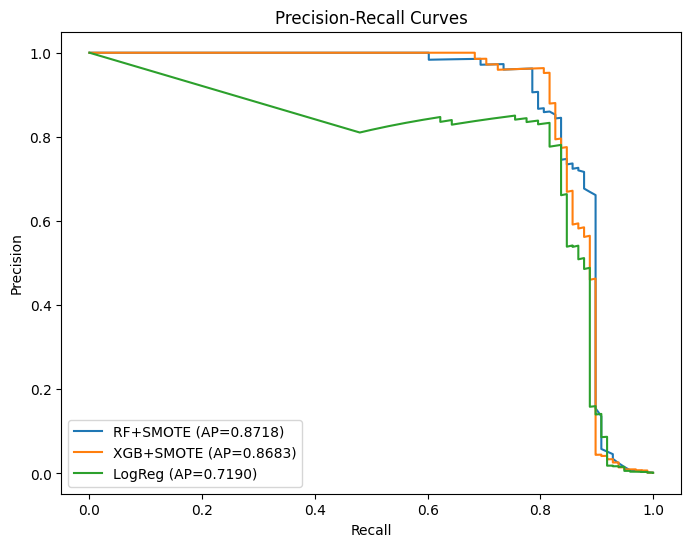

In [ ]:
plt.figure(figsize=(8,6))
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
ap = average_precision_score(y_test, y_proba_rf)
plt.plot(recall, precision, label=f'RF+SMOTE (AP={ap:.4f})')


precision_x, recall_x, _ = precision_recall_curve(y_test, y_proba_xgb)
ap_x = average_precision_score(y_test, y_proba_xgb)
plt.plot(recall_x, precision_x, label=f'XGB+SMOTE (AP={ap_x:.4f})')


precision_b, recall_b, _ = precision_recall_curve(y_test, y_proba)
ap_b = average_precision_score(y_test, y_proba)
plt.plot(recall_b, precision_b, label=f'LogReg (AP={ap_b:.4f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

Selected best model based on ROC AUC


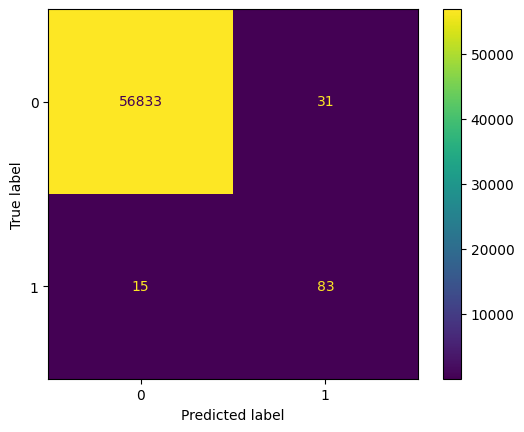

Saved model to /content/fraud_detection_model.pkl


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
best_model = pipe_xgb if roc_auc_score(y_test, y_proba_xgb) >= roc_auc_score(y_test, y_proba_rf) else pipe_rf
print('Selected best model based on ROC AUC')


y_best = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_best)
plt.show()


# --------------------
# Cell 14: Save the model
# --------------------
model_path = '/content/fraud_detection_model.pkl'
joblib.dump(best_model, model_path)
print('Saved model to', model_path)

In [ ]:
from google.colab import files as gfiles
gfiles.download(model_path)



import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': RANDOM_SEED
    }
    clf = xgb.XGBClassifier(**param)
    pipe = ImbPipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=RANDOM_SEED)), ('clf', clf)])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
print('Best trial:', study.best_trial.params)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[I 2025-11-07 06:38:02,618] A new study created in memory with name: no-name-9a245cd9-f3ae-42de-9359-93c25a140fc0
[I 2025-11-07 06:40:07,734] Trial 0 finished with value: 0.9821093395409344 and parameters: {'n_estimators': 394, 'max_depth': 12, 'learning_rate': 0.03370226025804538, 'subsample': 0.9437272850795608, 'colsample_bytree': 0.729433288599155}. Best is trial 0 with value: 0.9821093395409344.
[I 2025-11-07 06:40:32,908] Trial 1 finished with value: 0.975016834581214 and parameters: {'n_estimators': 85, 'max_depth': 7, 'learning_rate': 0.02895250200358096, 'subsample': 0.959734499269689, 'colsample_bytree': 0.9485161525985045}. Best is trial 0 with value: 0.9821093395409344.
[I 2025-11-07 06:41:42,855] Trial 2 finished with value: 0.9795039119914848 and parameters: {'n_estimators': 348, 'max_depth': 7, 'learning_rate': 0.02450102175707524, 'subsample': 0.8386614043538088, 'colsample_bytree': 0.6520954172926168}. Best is trial 0 with value: 0.9821093395409344.
[I 2025-11-07 06:42

Best trial: {'n_estimators': 299, 'max_depth': 11, 'learning_rate': 0.12172802845100548, 'subsample': 0.9901400930843944, 'colsample_bytree': 0.5905858739389642}


In [6]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.8 MB/s eta 0:00:00


In [9]:
import optuna
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's Pipeline for SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification # Example data

# --- 1. Define Constants and Load Data ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# **EXAMPLE DATA LOADING** (Replace with your actual data loading)
# Create some synthetic data for a classification task
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5,
                           n_redundant=0, n_classes=2, flip_y=0.1,
                           n_clusters_per_class=1, weights=[0.9, 0.1], # Create imbalance
                           random_state=RANDOM_SEED)

# Split data into training and (optional) testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=RANDOM_SEED)
# --- X_train and y_train are now DEFINED and available globally ---


# --- 2. Define the Objective Function ---
def objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    """
    # Hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # Removed 'use_label_encoder' and 'eval_metric' for modern XGBoost versions
        # 'use_label_encoder': False,
        # 'eval_metric': 'logloss',
        'random_state': RANDOM_SEED,
        'tree_method': 'hist' # Recommended for performance
    }

    # Initialize the classifier
    clf = xgb.XGBClassifier(**param)

    # Create the imbalanced-learn pipeline
    # Note: SMOTE should be applied ONLY to the training data within the CV folds,
    # which is handled correctly by including it in the pipeline passed to cross_val_score.
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_SEED)),
        ('clf', clf)
    ])

    # Perform cross-validation and get scores
    # X_train, y_train, cv=3, scoring='roc_auc' are defined/available globally
    scores = cross_val_score(
        estimator=pipe,
        X=X_train,
        y=y_train,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Return the mean ROC AUC score
    return np.mean(scores)


# --- 3. Run Optimization ---
# The study creates a new experiment and stores results
study = optuna.create_study(direction='maximize', study_name='XGBoost_Hyperopt')

# Run the optimization for 25 trials
# This is where the objective function is repeatedly called
study.optimize(objective, n_trials=25)

# --- 4. Print Results ---
print('\n✨ Optimization Finished ✨')
print(f'Best ROC AUC: {study.best_value:.4f}')
print('Best Parameters:')
# The result from your original print statement
# print('Best trial:', study.best_trial.params)
for key, value in study.best_trial.params.items():
    print(f'  {key}: {value}')

[I 2025-11-07 11:27:06,008] A new study created in memory with name: XGBoost_Hyperopt
[I 2025-11-07 11:27:11,382] Trial 0 finished with value: 0.7802929327158402 and parameters: {'n_estimators': 260, 'max_depth': 7, 'learning_rate': 0.017472512898794885, 'subsample': 0.6217057956334668, 'colsample_bytree': 0.8587884605266367}. Best is trial 0 with value: 0.7802929327158402.
[I 2025-11-07 11:27:12,272] Trial 1 finished with value: 0.7890385556685117 and parameters: {'n_estimators': 397, 'max_depth': 6, 'learning_rate': 0.07577986967907376, 'subsample': 0.8262571189361572, 'colsample_bytree': 0.7640830863356184}. Best is trial 1 with value: 0.7890385556685117.
[I 2025-11-07 11:27:13,831] Trial 2 finished with value: 0.7762801686810498 and parameters: {'n_estimators': 216, 'max_depth': 8, 'learning_rate': 0.017001287331287366, 'subsample': 0.7873597335263158, 'colsample_bytree': 0.9032299433836366}. Best is trial 1 with value: 0.7890385556685117.
[I 2025-11-07 11:27:15,465] Trial 3 finish


✨ Optimization Finished ✨
Best ROC AUC: 0.8100
Best Parameters:
  n_estimators: 347
  max_depth: 6
  learning_rate: 0.24947703519841977
  subsample: 0.5554630971076934
  colsample_bytree: 0.937858561190841


In [10]:
# Assuming 'study', 'RANDOM_SEED', 'X_train', and 'y_train' are defined
# and necessary libraries (xgb, ImbPipeline, StandardScaler, SMOTE) are imported.

## 🛠️ Corrected Final Model Training

# 1. Get the best parameters from the Optuna study
best_params = study.best_trial.params

# 2. Add or override fixed parameters.
#    Note: 'use_label_encoder' and 'eval_metric' are often unnecessary/deprecated
#    in recent XGBoost versions. They are included here for compatibility
#    with your original code's intent but are often best left out.
best_params['random_state'] = RANDOM_SEED
# best_params['use_label_encoder'] = False # Usually unnecessary
# best_params['eval_metric'] = 'logloss'   # Usually unnecessary

# 3. Instantiate the XGBoost classifier with the best parameters
best_model = xgb.XGBClassifier(**best_params)

# 4. Define the final pipeline using the best model
#    This structure ensures SMOTE is applied correctly before training the classifier.
final_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('clf', best_model)
])

# 5. Train the final pipeline on the full training data
final_pipeline.fit(X_train, y_train)
print("✅ Final model trained successfully!")

✅ Final model trained successfully!


In [11]:
import joblib

joblib.dump(final_pipeline, "fraud_detection_model.pkl")
print("✅ Model saved as fraud_detection_model.pkl")


✅ Model saved as fraud_detection_model.pkl


In [12]:
from google.colab import files
files.download("fraud_detection_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

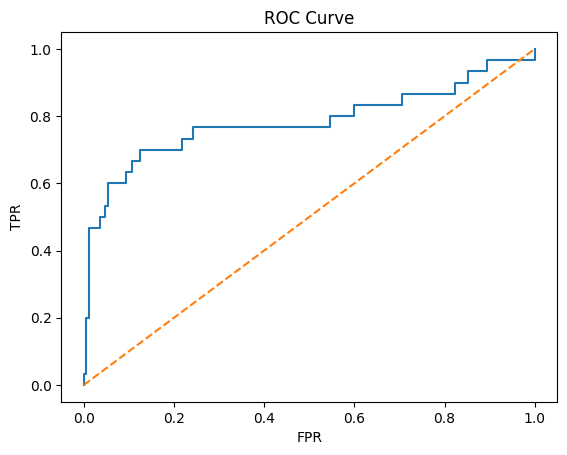

✅ All results saved!


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import joblib

# Predictions
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Save Classification Report
report = classification_report(y_test, y_pred)
with open("classification_report.txt", "w") as f:
    f.write(report)

# Save Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("roc_curve.png")
plt.show()

# Already saved model file:
joblib.dump(final_pipeline, "fraud_detection_model.pkl")

print("✅ All results saved!")


In [14]:
from google.colab import files
files.download("fraud_detection_model.pkl")
files.download("classification_report.txt")
files.download("confusion_matrix.csv")
files.download("roc_curve.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>